In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import imread, showMatches
from detectBlobs import detectBlobs
from drawBlobs import drawBlobs
from skimage.color import rgb2gray
from scipy.ndimage.filters import convolve
from compute_sift import compute_sift
from computeMatches import computeMatches
from mergeImages import mergeImages
from ransac import ransac

import sys
%matplotlib inline

In [2]:
#Image directory
dataDir = os.path.join('..', 'data', 'stitching')

#Read input images
testExamples = ['hill', 'field', 'ledge', 'pier', 'river' 'roofs', 'building', 'uttower']
exampleIndex = 0
imageName1 = '{}1_r.jpg'.format(testExamples[exampleIndex])
imageName2 = '{}2_r.jpg'.format(testExamples[exampleIndex])

im1 = imread(os.path.join(dataDir, imageName1))
im2 = imread(os.path.join(dataDir, imageName2))

In [3]:
#Detect keypoints
blobs1 = detectBlobs(im1, {'level': 12})
blobs2 = detectBlobs(im2, {'level': 12})

#Compute SIFT features
# sift1 = compute_sift(im1, blobs1[:, 0:3])
# sift2 = compute_sift(im2, blobs2[:, 0:3])

# #Find the matching between features
# matches = computeMatches(sift1, sift2)
# showMatches(im1, im2, blobs1, blobs2, matches)

#Ransac to find correct matches and compute transformation
#inliers, transf = ransac(matches, blobs1, blobs2)

Convolving with sigma=1.2
Convolving with sigma=1.6099689438
Convolving with sigma=2.16
Convolving with sigma=2.89794409884
Convolving with sigma=3.888
Convolving with sigma=5.21629937791
Convolving with sigma=6.9984
Convolving with sigma=9.38933888024
Convolving with sigma=12.59712
Convolving with sigma=16.9008099844
Convolving with sigma=22.674816
Convolving with sigma=30.421457972
Iterating for Level=0
Iterating for Level=1
Iterating for Level=2
Iterating for Level=3
Iterating for Level=4
Iterating for Level=5
Iterating for Level=6
Iterating for Level=7
Iterating for Level=8
Iterating for Level=9
Iterating for Level=10
Iterating for Level=11
Convolving with sigma=1.2
Convolving with sigma=1.6099689438
Convolving with sigma=2.16
Convolving with sigma=2.89794409884
Convolving with sigma=3.888
Convolving with sigma=5.21629937791
Convolving with sigma=6.9984
Convolving with sigma=9.38933888024
Convolving with sigma=12.59712
Convolving with sigma=16.9008099844
Convolving with sigma=22.67

In [4]:
sift1 = compute_sift(im1, blobs1)
sift2 = compute_sift(im2, blobs2)

# #Find the matching between features
matches = computeMatches(sift1, sift2)
print (matches.shape)
#showMatches(im1, im2, blobs1, blobs2, matches)

(140,)


In [37]:
matches = computeMatches(sift1, sift2)
print (matches.shape)

(140,)


In [224]:
#blobs1, blobs2 = blobs1[:, [0, 1, 3]], blobs2[:, [0, 1, 3]]

pairs = int(matches.shape[0] * .3)
max_iteration = 500
reject_limit = 2000

match_blob1 = blobs1[matches]
match_blob2 = blobs2[matches]

In [231]:
def ransac3(matches, blobs1, blobs2, param={}):
    pairs = int(matches.shape[0] * .3)
    default_max_itr, default_reject_limit = 1000, 1000
    max_iteration = param.get("max_iteration") if param.get("max_iteration") is not None else default_max_itr
    reject_limit = param.get("reject_limit") if param.get("reject_limit") is not None else default_reject_limit
    
    match_blob1 = blobs1[matches]
    match_blob2 = blobs2[matches]
    total_inliers, best_inlier_model = 0, np.zeros(matches.shape[0])
    for n in range(max_iteration):
        idxs = np.random.choice(matches.shape[0], pairs)
        matching1 = match_blob1[idxs, :]
        matching2 = match_blob2[idxs, :]
        transf = np.linalg.lstsq(matching2, matching1, rcond=None)[0]
        transf[:, 2] = np.array([0, 0, 1])
        curr_inliers = np.power(np.linalg.norm(np.dot(match_blob2, transf) - match_blob1, axis=1), 2) < reject_limit
        if curr_inliers.sum() > total_inliers:
            print ("Uauua")
            total_inliers = curr_inliers.sum()
            best_inlier_model = curr_inliers.copy()     
    transf = np.linalg.lstsq(match_blob2[best_inlier_model], match_blob1[best_inlier_model], rcond=None)[0]
    
    if np.sum(transf - np.eye(3)) == 0:
        best_inlier_model = -1
    
    return best_inlier_model, transf[:2, :3]

Uauua
Uauua
Uauua
Uauua
Uauua
Uauua
Uauua
Uauua


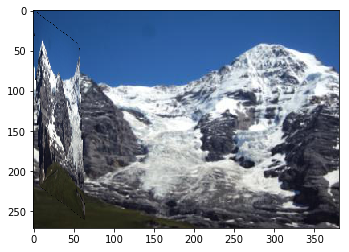

In [395]:
inliers, transf = ransac3(matches, blobs1, blobs2, {'max_iteration': 1000, 'reject_limit': 1000})
goodMatches = np.zeros_like(matches)
goodMatches[inliers] = matches[inliers]

stitchIm = mergeImages(im2, im1, transf)
plt.figure()
plt.imshow(stitchIm)

In [396]:
transf

array([[ 1.49234174e-01,  2.92395411e-02,  1.09969850e-18],
       [ 1.11817110e-01,  8.07801043e-01, -1.87118656e-18]])

In [291]:
goodMatches

array([   0,    0,    0,    0,   48,    0,    0,    0,    0,    0,   92,
        107,  119,    0,    0,    0,  176,    0,    0,  282,    0,    0,
          0,    0,    0,  358,    0,    0,  373,  375,    0,    0,    0,
          0,    0,  448,  449,  460,    0,  485,  490,    0,  519,    0,
          0,  527,    0,    0,    0,    0,    0,    0,  577,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0, 1212,    0, 1223,    0,    0,    0, 1239, 1240,    0,    0,
          0, 1258,    0, 1267, 1268, 1275,    0,    0,    0,    0,    0,
          0,    0,    0,    0, 1373,    0,    0,    0])

In [225]:
total_inliers, best_inlier_model = 0, np.zeros(matches.shape[0])
for n in range(max_iteration):
    idxs = np.random.choice(matches.shape[0], pairs)
    matching1 = match_blob1[idxs, :]
    matching2 = match_blob2[idxs, :]
    transf = np.linalg.lstsq(matching2, matching1, rcond=None)[0]
    transf[:, 2] = np.array([0, 0, 1])
    #print (np.power(np.linalg.norm(np.dot(match_blob2, transf) - match_blob1, axis=1), 2))
    curr_inliers = np.power(np.linalg.norm(np.dot(match_blob2, transf) - match_blob1, axis=1), 2) < reject_limit
    if curr_inliers.sum() > total_inliers: print (curr_inliers.sum())
    if curr_inliers.sum() > total_inliers:
        total_inliers = curr_inliers.sum()
        best_inlier_model = curr_inliers.copy()     
transf = np.linalg.lstsq(match_blob2[best_inlier_model], match_blob1[best_inlier_model], rcond=None)[0]

if np.sum(transf - np.eye(3)) == 0:
    best_inlier_model = -1

31
Uauua
34
Uauua
36
Uauua
37
Uauua
40
Uauua
42
Uauua


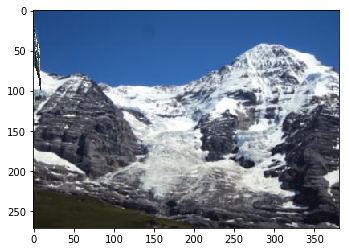

In [235]:
#inliers, transf = best_inlier_model, transf[:2, :3]
goodMatches = np.zeros_like(matches)
goodMatches[inliers] = matches[inliers]
#showMatches(im1, im2, blobs1, blobs2, goodMatches)
from mergeImages import mergeImages
stitchIm = mergeImages(im2, im1, transf)
plt.figure()
plt.imshow(stitchIm)

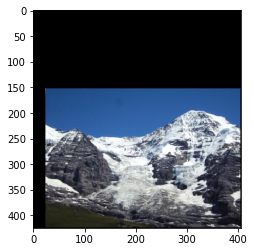

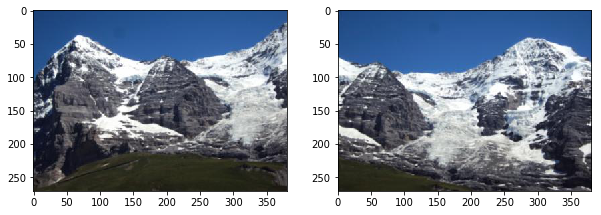

In [47]:
testExamples = ['hill', 'field', 'ledge', 'pier', 'river' 'roofs', 'building', 'uttower']
exampleIndex = 0
imageName1 = '{}1_r.jpg'.format(testExamples[exampleIndex])
imageName2 = '{}2_r.jpg'.format(testExamples[exampleIndex])

im1 = imread(os.path.join(dataDir, imageName1))
im2 = imread(os.path.join(dataDir, imageName2))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(im1)
plt.subplot(1, 2, 2)
plt.imshow(im2)

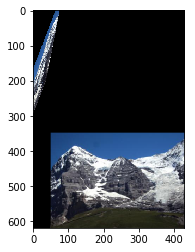

In [ ]:
reject_limit = .55
    matches = []
    distance_matrix = cdist(f1, f2)
    
    smallest = f1
    if (f1.shape[0] > f2.shape[0]):
        smallest = f2
    
    for n in range(smallest.shape[0]):
        currd_matrix = distance_matrix[n]
        if (np.min(currd_matrix) / np.partition(currd_matrix, 2)[1]) <= reject_limit:
            matches.append([n])
    matches = np.squeeze(np.array(matches))
    return matches

In [9]:
inliers, transf = ransac(matches, blobs1, blobs2)

ValueError: could not broadcast input array from shape (3) into shape (5)